In [1]:
##==================================================
##
## Script name: Heterogenous Panel Simulation
##
##
## Purpose of script: Given different parametrizations of
##                    recruitment patterns and outcomes,
##                    simulate a panel of heterogeneous
##                    treatment effects for stress testing the MC estimator
## Author: Shosh Vasserman
##
## Date Last Edited: 09-27-2021
##
## Email: svass@stanford.edu
##
## Input:  TBC

In [17]:
# Imports
using Distributions
using LinearAlgebra
using DataFrames, CSV
using Distributions
using Random
using Plots

In [3]:
# Type definitions

mutable struct Date
    id::Integer ## day of the year
    X::AbstractFloat ## This could be a date fixed effect or a vector of date characteristics
end

mutable struct BasicOutcome
    date::Integer ## date of trip
    y::AbstractFloat ## outcome
end

mutable struct BasicRider
    id::Integer ## rider ID
    cohort_id::Integer ## rider's cohord ID -- in order of the cohort array
    X::Vector{AbstractFloat}  ## rider characteristics
    init_date::Integer ## Rider's date of entry
    min_date::Integer ## First date anyone in the cohort can enter; Assume time is indexed from 0 to 365
    max_date::Integer ## Laste date anyone in the cohort can enter; Note -- cohort entries may overlap (maybe...)
    outcomes::Vector{BasicOutcome} ## outcome draws
end

mutable struct BasicCohort
    init_coeff::AbstractFloat ## alpha_t for the cohort
end


In [4]:
## Set seed
rng_seed = MersenneTwister(1234);

In [43]:
## Define Options

global init_date_fn_of_X = false
global te_fn_of_X = true
global te_fn_of_time = true
global cap_treated_time = false
global fix_cohort_dates = true

global T_timescale = 78 ## 1.5 years
global T_monitoring = 24 ## duration of monitoring period in weeks
global N_cohort = 3
global Quota = N_cohort*500

global dim_indivX = 5;
global logit_scaler = 15;

In [44]:
## Define Distributions and transformations

## Simulates a random multidimensional Gaussian distribution with dimension d
function get_mvnormal_dist(d = dim_indivX, η = 1)
    # Dimensionality
    # d = 5
    # η = 1 # Uniform distribution over correlation matrices

    # Distribution setup
    Ω_dist = LKJ(d, η)
    σ_dist = InverseGamma(2, 3)
    μ_dist = MvNormal(5, 1)

    # Draw values
    Ω = rand(Ω_dist)                 # Correlation matrix
    σ = sqrt.(rand(σ_dist, d))       # Individual standard deviations
    μ = rand(μ_dist)                 # Mean vector

    # Create covariance matrix
    # Need to specify Symmetric(...) to enforce symmetry, otherwise
    # possible non-Hermitian error.
    Σ = Symmetric(diagm(σ)*Ω*diagm(σ))

    # Create random mean/variance distribution
    mvnormal_dist = MvNormal(μ, Σ)
    return(mvnormal_dist)
end

## Inverse logit maps R -> [0,1]
function inv_logit(x)
   return exp.(x)./(1 .+ exp.(x)); 
end

## Logit maps [0,1] -> R
function logit(p)
   return log.(p ./ (1 .- p)) 
end

global indiv_ones = ones(dim_indivX);

In [45]:
## Define parameters

## Date fixed effects
global F_date_fe = Normal(0, .2);

## Individual characteristics
global indiv_X_dist = get_mvnormal_dist();


## Individual betas
global F_init_coef = Normal(0,2);
global F_outcome_coef = Normal(0.2,0.5);

## Treatment fixed effects
global F_treatment_fe = Normal(-1, 0.1);

## cohort bunching centers
global cohort_inits_centers = [15, 40, 60];
global F_cohort_inits_centers = Uniform(0,T_timescale); 

In [46]:
cohort_array = Array{BasicCohort}(undef, N_cohort);
date_array = Array{Date}(undef, T_timescale);
panel_array = Array{BasicRider}(undef, Quota);

function initialize_panel!(cohort_array, date_array, panel_array)
    
    ## Initialize cohort array
    for c in 1:N_cohort
        if !fix_cohort_dates
            cohort_init_draw = cohort_init_dist[c];
        else
            cohort_init_draw = rand(rng_seed, F_cohort_inits_centers);
        end
        draw = cohort_init_draw;
        cohort_array[c] = BasicCohort(draw);
    end
    

    ## Intialize date array
    for t in 1:T_timescale
        γ_t_draw = rand(rng_seed, F_date_fe);
        date_array[t] = Date(t, γ_t_draw)
    end
    
    ## Initialize panel of riders
    β_init_draw = rand(F_init_coef, 5);
    β_outcome_draw = rand(rng_seed, F_outcome_coef, 5);
    τ_draw = rand(rng_seed, F_treatment_fe);
    
    
    N_per_cohort = Integer(floor(Quota/N_cohort));
    for i in 1:N_per_cohort
        for c in 1:N_cohort
            
            ## initialize rider characteristics
            X_draw = rand(rng_seed, indiv_X_dist);
                        
            if init_date_fn_of_X
                inv_init_draw = cohort_array[c].init_coeff + β_init_draw'*X_draw;
            else
                inv_init_draw = cohort_array[c].init_coeff + β_init_draw'*indiv_ones;
            end
            
            t_i = round(inv_logit(inv_init_draw/logit_scaler) * T_timescale);
            init_date = t_i;
            min_date = max(t_i - T_monitoring,0);
            
            if cap_treated_time
                max_date = min(t_i + T_monitoring, T_timescale);
            else
                max_date = T_timescale;
            end
            
            rider_outcome_fe = β_outcome_draw'*X_draw;
            
            if te_fn_of_X
                rider_outcome_te_base = τ_draw * inv_logit(β_outcome_draw'*X_draw);
            else
                rider_outcome_te_base = τ_draw * inv_logit(β_outcome_draw'*indiv_ones);
            end
            
            function τ_decay(t) 
                if te_fn_of_time
                    τ_t = rider_outcome_te_base * inv_logit( (T_timescale-t)/T_timescale*20 ); ## This hits 1 after ~ 20 periods
                else
                    τ_t = rider_outcome_te_base;
                end
                
                return τ_t;
            end
            
            
            rider_outcomes_before_treatment = [BasicOutcome(t,rider_outcome_fe + γ_t_draw'*date_array[t].X) for t=min_date:init_date];
            rider_outcomes_after_treatment = [BasicOutcome(t,rider_outcome_fe + γ_t_draw'*date_array[t].X + τ_decay(t)) for t=(init_date+1):max_date];
    
            rider = BasicRider(i, c, X_draw, init_date, min_date, max_date, vcat(rider_outcomes_before_treatment, rider_outcomes_after_treatment));
            panel_array[N_per_cohort*(c-1)+i] = rider;
        end
    end
    
    
end

initialize_panel! (generic function with 2 methods)

In [47]:
initialize_panel!(cohort_array, date_array, panel_array)

LoadError: UndefVarError: γ_t_draw not defined

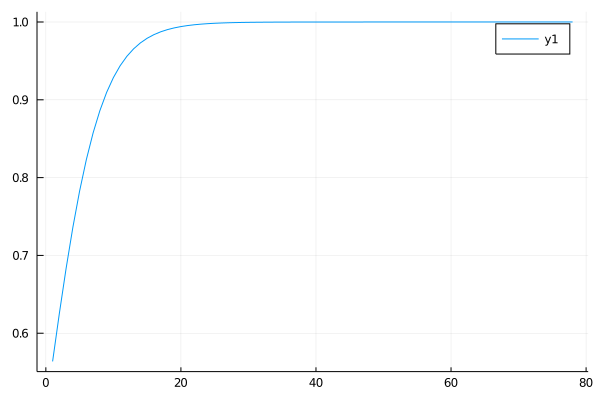

In [35]:
x = 1:T_timescale; y = inv_logit.(( x) ./ T_timescale .* 20)
plot(x, y)

In [27]:
y

100-element Array{Float64,1}:
 0.9999498278353163
 0.9999445514752772
 0.9999387202603834
 0.9999322758503802
 0.9999251537724894
 0.9999172827771483
 0.9999085841261478
 0.9998989708060922
 0.9998883466593704
 0.9998766054240138
 0.9998636296729205
 0.9998492896419402
 0.9998334419352226
 ⋮
 0.7502601055951176
 0.7310585786300049
 0.710949502625004
 0.6899744811276125
 0.6681877721681662
 0.6456563062257955
 0.6224593312018546
 0.598687660112452
 0.574442516811659
 0.549833997312478
 0.52497918747894
 0.5